### Business Understanding

The film industry is characterized by significant financial investment and protracted production schedules. Contemporary film budgets can vary dramatically, spanning from \$1 million for independent productions to exceeding \$1.5 billion for major studio releases and take years to release. Investors are primarily concerned with recouping these substantial costs and generating profit. Therefore, understanding the determinants of box office revenue is essential. This study investigates the elements that significantly influence a film's commercial performance.

**Load Python Libraries**: Load required Python libraries.

In [ ]:
!pip install category_encoders
from category_encoders import JamesSteinEncoder, LeaveOneOutEncoder, CatBoostEncoder
from sklearn import set_config
set_config(display="diagram")
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import kagglehub
import nltk
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import re
import seaborn as sns
import time

from itertools import chain
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from warnings import simplefilter
from xgboost import XGBRegressor
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00


### Data Understanding

**Load Kaggle DataSet**: Load Kaggle TMDB Movie Dataset.

In [ ]:
path = kagglehub.dataset_download("asaniczka/tmdb-movies-dataset-2023-930k-movies")
movies = pd.read_csv(path + "/TMDB_movie_dataset_v11.csv")

100%|██████████| 213M/213M [00:04<00:00, 53.4MB/s]

Extracting files...


**Data Cleaning**: The following data cleaning tasks are performed:

1. Remove revenue outliers by removing all rows where revenue is \$0 and revenue is above \$1.500.000.000.
2. Separate release date into two columns release month and release year.
3. Fill the NAs of release month and release year with the most frequent value.
4. Fill the NAs in text columns with an empty string.
5. Numeric columns don't have NAs.
6. As the dataset has multiple multi valued columns (comma separated values), extract the individual values and calculated the impact of each individual value to the target variable (revenue) mean. Show the top values that impact the target variable (revenue) per column. The information gather in this task will be used to create boolean columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208039 entries, 0 to 1208038
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1208039 non-null  Int64  
 1   title                 1208026 non-null  string 
 2   vote_average          1208039 non-null  Float64
 3   vote_count            1208039 non-null  Int64  
 4   status                1208039 non-null  string 
 5   release_date          990151 non-null   string 
 6   revenue               1208039 non-null  Int64  
 7   runtime               1208039 non-null  Int64  
 8   adult                 1208039 non-null  boolean
 9   backdrop_path         315175 non-null   string 
 10  budget                1208039 non-null  Int64  
 11  homepage              126977 non-null   string 
 12  imdb_id               619329 non-null   string 
 13  original_language     1208039 non-null  string 
 14  original_title        1208026 non-

<ipython-input-4-2778b9696563>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_without_outliers['release_year'] = movies_without_outliers.release_date.str.split('-').str[0]
<ipython-input-4-2778b9696563>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_without_outliers['release_month'] = movies_without_outliers.release_date.str.split('-').str[1]
<ipython-input-4-2778b9696563>:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using a

,Description,Value
0,Row count revenue $0,1186308
1,Row count revenue over $1.500.000.000,16
2,Row count before,1208039
3,Row count after,21714
4,Revenue mean,35610926.224141
5,Revenue variance,12621653464861696.0


,0
id,0
title,0
vote_average,0
vote_count,0
status,0
release_date,2395
revenue,0
runtime,0
adult,0
backdrop_path,5404


<ipython-input-4-2778b9696563>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_without_outliers[column_name] = movies_without_outliers[column_name].apply(lambda value: convert_to_word_list(value))
<ipython-input-4-2778b9696563>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)
<ipython-input-4-2778b9696563>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

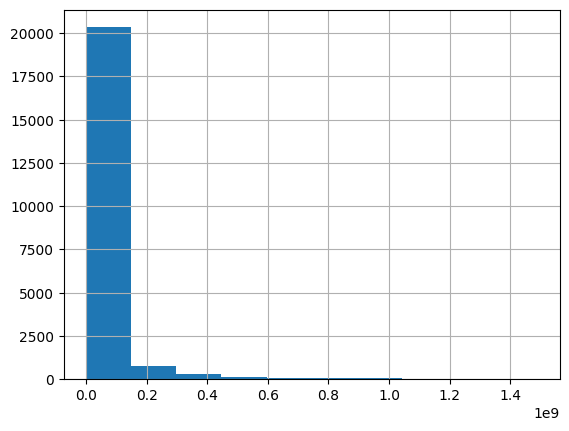

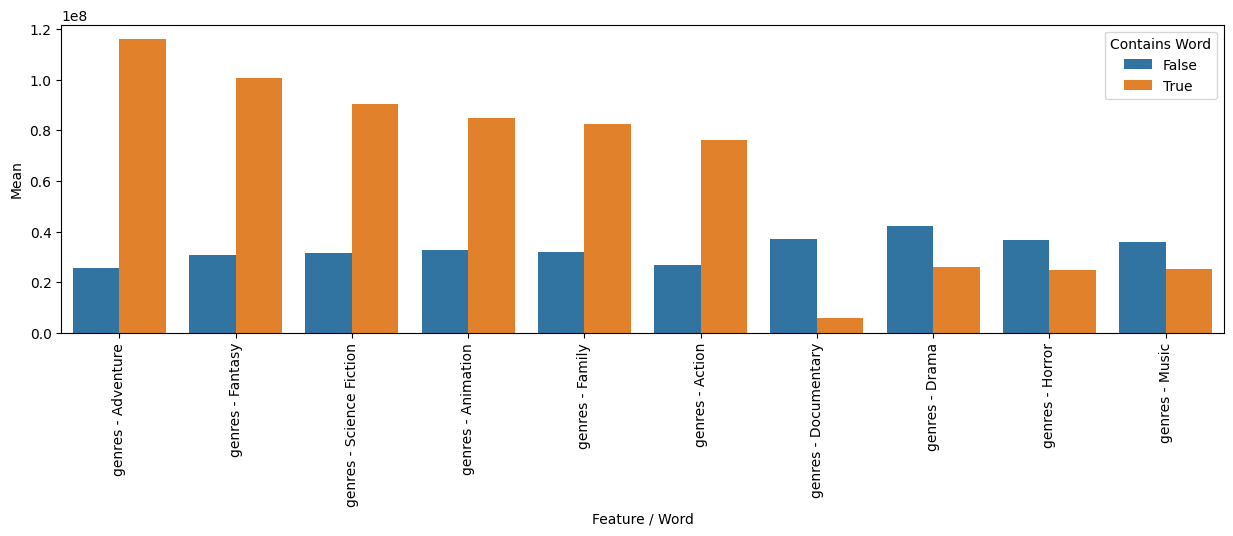

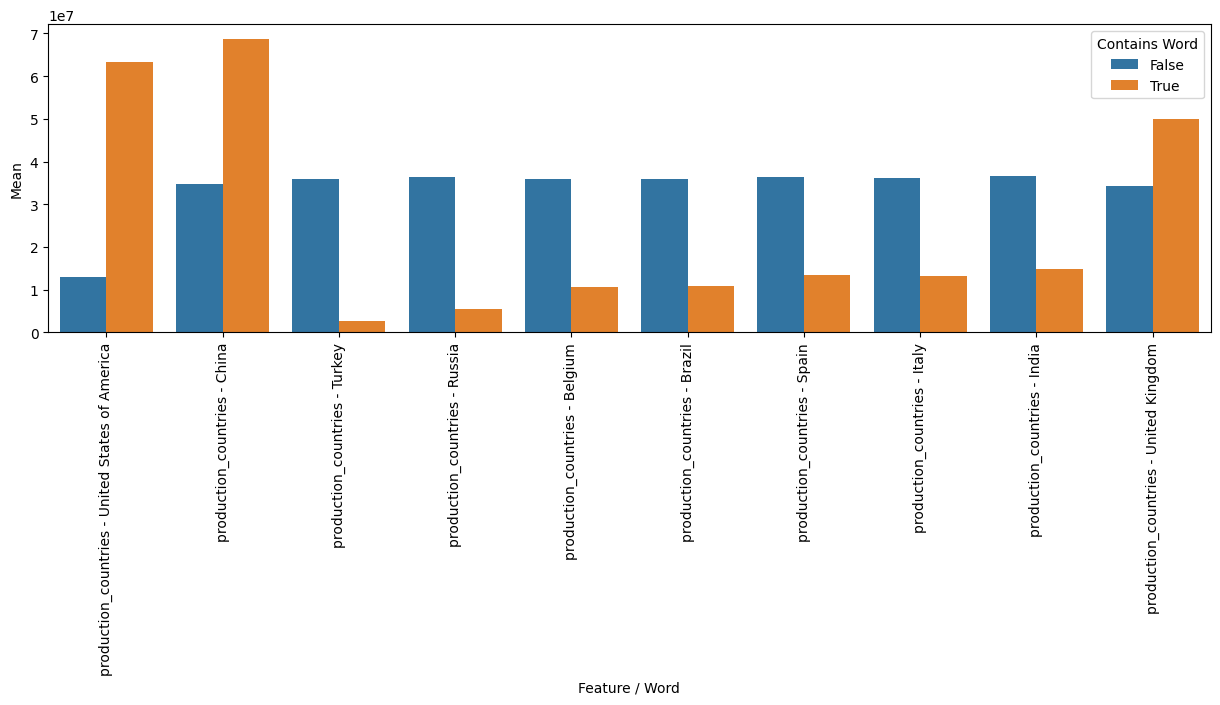

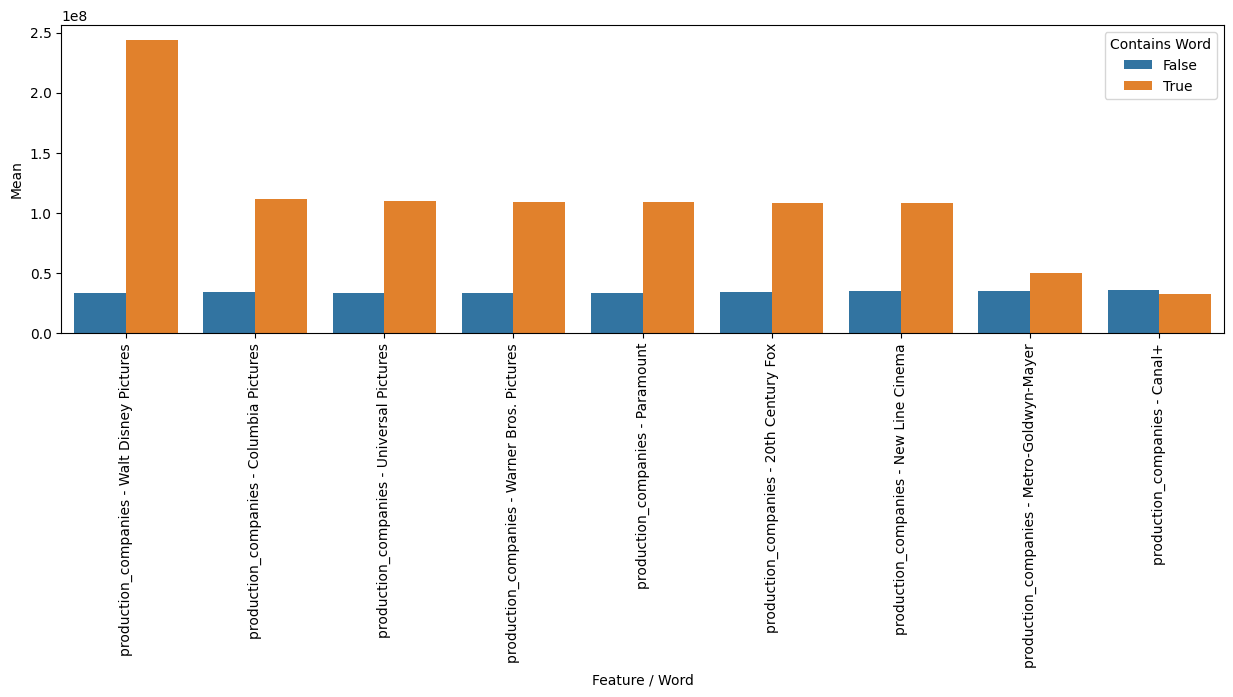

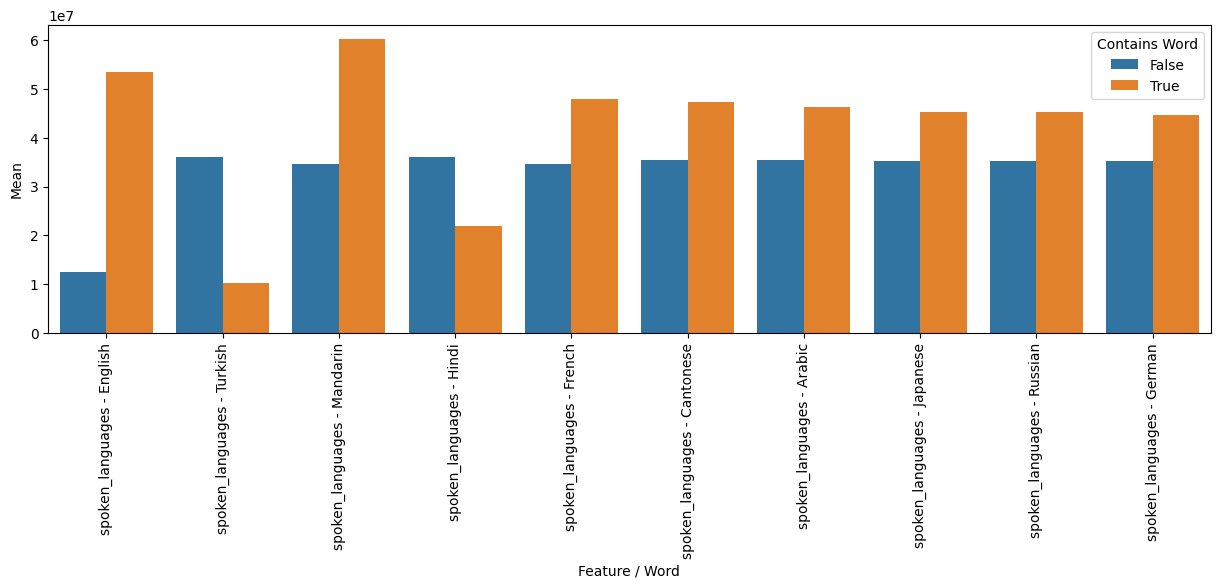

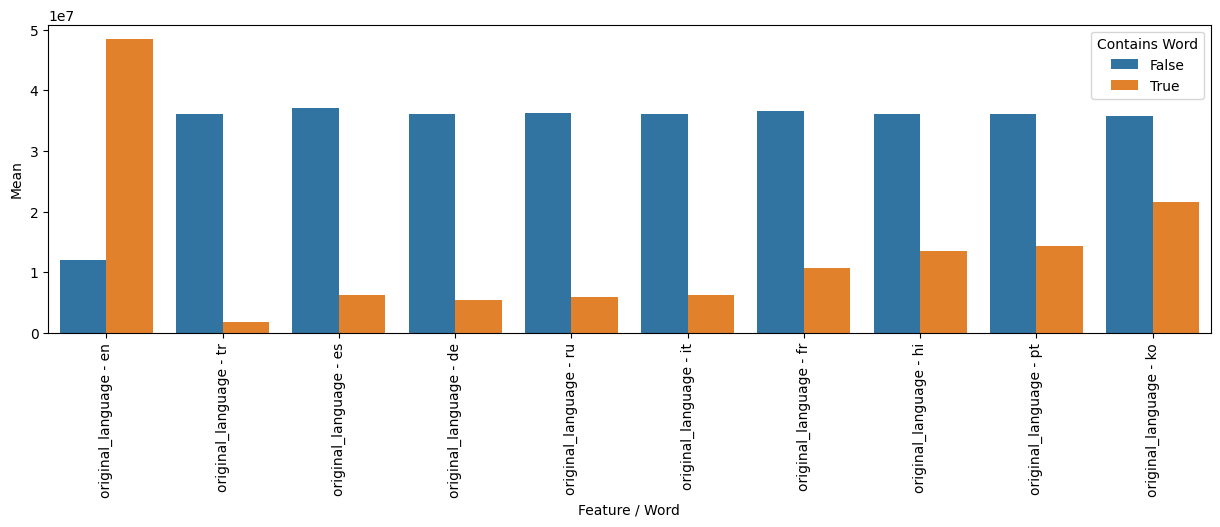

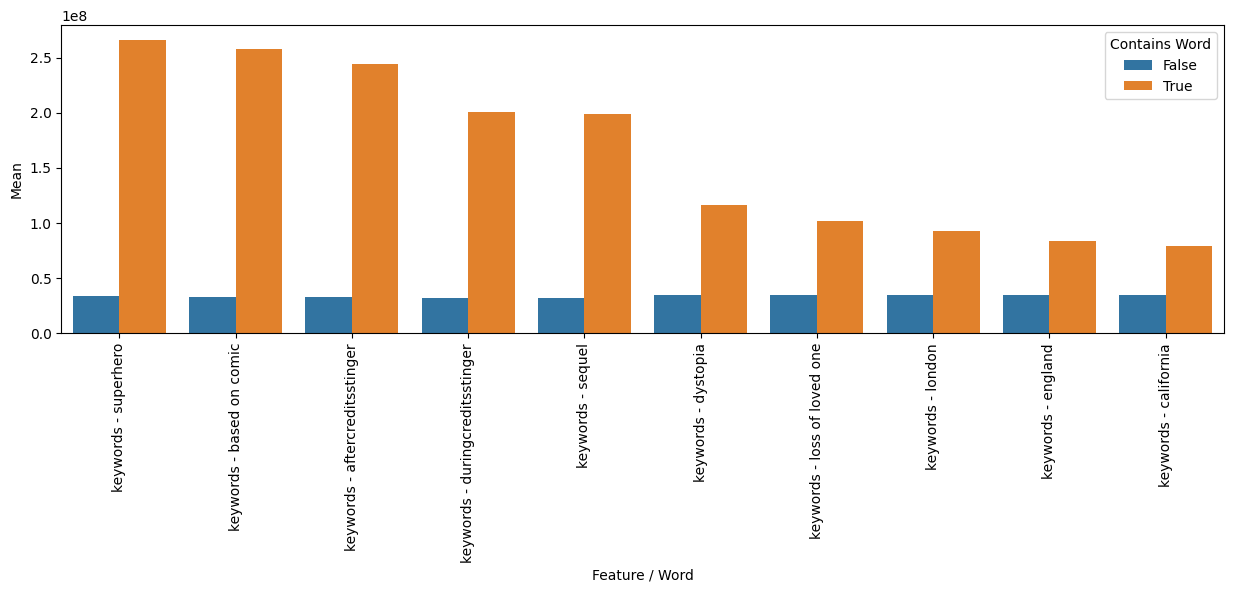

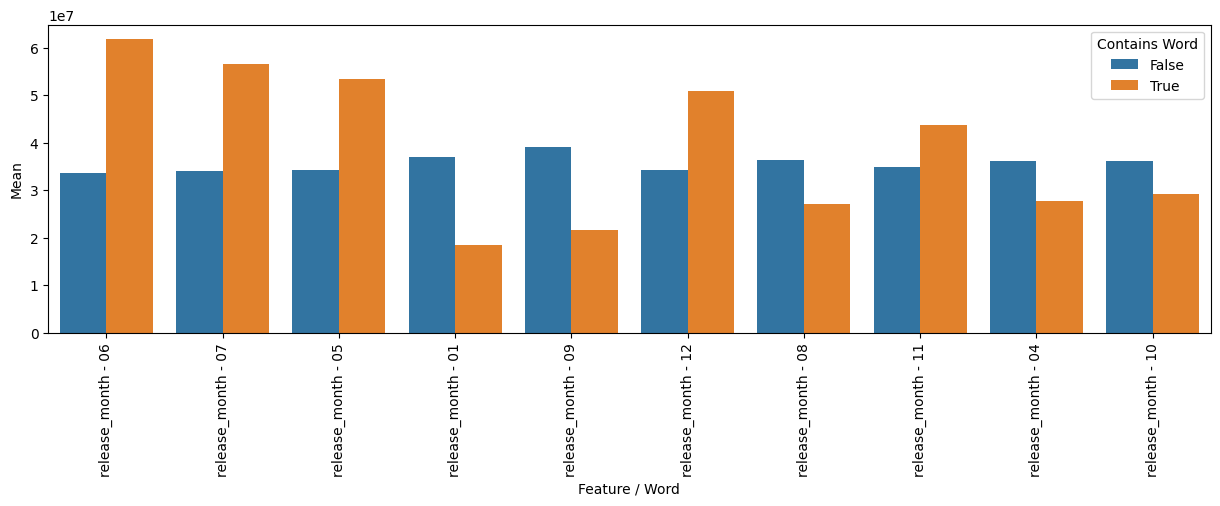

In [ ]:
def convert_to_word_list(text):
  word_list = set()

  if not(pd.isnull(text)):
    word_list = { word.strip() for word in text.split(',') }

  return word_list

def get_unique_word_list(series):
  unique_word_list = set()
  for word_list in series:
    unique_word_list.update(word_list)

  return unique_word_list

multi_value_columns = [ 'genres', 'production_countries', 'production_companies', 'spoken_languages', 'original_language', 'keywords', 'release_month' ]
categorial_columns = [ 'adult' ]
numerical_columns = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count', 'release_year']
text_columns = ['title', 'original_title', 'overview', 'tagline']

movies = movies.convert_dtypes()
movies.info()
table_summary = []
row_count = len(movies[movies['revenue'].eq(0)])
table_summary.append({ 'Description': 'Row count revenue $0', 'Value': str(row_count) })
row_count = len(movies[movies['revenue'].gt(1500000000)])
table_summary.append({ 'Description': 'Row count revenue over $1.500.000.000', 'Value': str(row_count) })
movies_without_outliers = movies[movies['revenue'].gt(0) & movies['revenue'].le(1500000000)]
movies_without_outliers['release_year'] = movies_without_outliers.release_date.str.split('-').str[0]
movies_without_outliers['release_month'] = movies_without_outliers.release_date.str.split('-').str[1]
movies_without_outliers['release_year'].fillna('2017', inplace=True)
movies_without_outliers['release_month'].fillna('09', inplace=True)
movies_without_outliers[text_columns] = movies_without_outliers[text_columns].fillna('')
revenue_mean = movies_without_outliers['revenue'].mean()
revenue_var = movies_without_outliers['revenue'].var()
table_summary.append({ 'Description': 'Row count before', 'Value': str(len(movies)) })
table_summary.append({ 'Description': 'Row count after', 'Value': str(len(movies_without_outliers)) })
table_summary.append({ 'Description': 'Revenue mean', 'Value': revenue_mean })
table_summary.append({ 'Description': 'Revenue variance', 'Value': revenue_var} )
movies_without_outliers['revenue'].hist()
display(pd.DataFrame(table_summary))
display(movies_without_outliers.isna().sum())

# Minimum number of rows (1%) that need to contain the value so the mean is significant.
min_revenue_diff = 200

revenue_means = []
for column_name in multi_value_columns:
  movies_without_outliers[column_name] = movies_without_outliers[column_name].apply(lambda value: convert_to_word_list(value))

  unique_word_list = get_unique_word_list(
    movies_without_outliers[column_name]
  )

  column_revenue_means = []
  for word in unique_word_list:
    column_revenue_with_word = movies_without_outliers.loc[movies_without_outliers[column_name].apply(lambda word_list: word in word_list), 'revenue']
    column_revenue_without_word = movies_without_outliers.loc[movies_without_outliers[column_name].apply(lambda word_list: word not in word_list), 'revenue']
    if len(column_revenue_with_word) >= min_revenue_diff and len(column_revenue_without_word) >= min_revenue_diff:
      column_revenue_mean_diff = abs(column_revenue_with_word.mean() - column_revenue_without_word.mean())
      column_revenue_means.append({ 'Feature': column_name, 'Word': word, 'Feature / Word': column_name + ' - ' + word, 'Contains Word': True, 'Mean': column_revenue_with_word.mean(), 'Diff': column_revenue_mean_diff })
      column_revenue_means.append({ 'Feature': column_name, 'Word': word, 'Feature / Word': column_name + ' - ' + word, 'Contains Word': False, 'Mean': column_revenue_without_word.mean(), 'Diff': column_revenue_mean_diff })
  if column_revenue_means:
    plt.figure(figsize=(15,4))
    bar_plot = sns.barplot(pd.DataFrame(column_revenue_means).sort_values(by='Diff', ascending=False).head(20), x='Feature / Word', y='Mean', hue='Contains Word')
    bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)
    revenue_means += column_revenue_means


### Data Preparation

**Feature Engineering**: Because the dataset multi valued columns (comma separated values) convert each value into a boolean column.

In [ ]:
def fill_bool_column(word):
  def f(word_list):
    return not(pd.isnull(word_list)) and word in word_list

  return f

def fill_bool_columns(column_name, word, index):
  prepared_movies[f"bool_{index}_{column_name}_{word.replace(' ', '_')}"] = (
      prepared_movies[column_name].apply(fill_bool_column(word))
  )

prepared_movies = movies_without_outliers.copy()

revenue_means_df = pd.DataFrame(revenue_means)
revenue_means_df = revenue_means_df[revenue_means_df['Contains Word']]
revenue_means_df = revenue_means_df.sort_values(by='Diff', ascending=False)
display(revenue_means_df)
index1 = 1
for index2, row in revenue_means_df.iterrows():
  fill_bool_columns(row['Feature'], row['Word'], index1)
  index1 = index1 + 1

prepared_movies.drop(columns=multi_value_columns, axis=1, inplace=True)

prepared_movies = prepared_movies.convert_dtypes()
prepared_movies.info(verbose=True)

categorical_columns = [ 'adult' ]
for c in prepared_movies.columns:
  if c.startswith('bool_'):
    categorical_columns.append(c)

,Feature,Word,Feature / Word,Contains Word,Mean,Diff
148,keywords,superhero,keywords - superhero,True,2.663899e+08,2.330869e+08
166,keywords,based on comic,keywords - based on comic,True,2.581857e+08,2.251462e+08
206,keywords,aftercreditsstinger,keywords - aftercreditsstinger,True,2.441721e+08,2.112758e+08
84,production_companies,Walt Disney Pictures,production_companies - Walt Disney Pictures,True,2.442458e+08,2.107115e+08
178,keywords,duringcreditsstinger,keywords - duringcreditsstinger,True,2.003685e+08,1.683551e+08
144,keywords,sequel,keywords - sequel,True,1.986233e+08,1.664543e+08
4,genres,Adventure,genres - Adventure,True,1.160194e+08,9.058308e+07
180,keywords,dystopia,keywords - dystopia,True,1.166568e+08,8.190969e+07
78,production_companies,Columbia Pictures,production_companies - Columbia Pictures,True,1.116006e+08,7.785412e+07
80,production_companies,Universal Pictures,production_companies - Universal Pictures,True,1.096850e+08,7.646878e+07


<class 'pandas.core.frame.DataFrame'>
Index: 21714 entries, 0 to 1207036
Data columns (total 141 columns):
 #    Column                                                 Dtype  
---   ------                                                 -----  
 0    id                                                     Int64  
 1    title                                                  string 
 2    vote_average                                           Float64
 3    vote_count                                             Int64  
 4    status                                                 string 
 5    release_date                                           string 
 6    revenue                                                Int64  
 7    runtime                                                Int64  
 8    adult                                                  boolean
 9    backdrop_path                                          string 
 10   budget                                                 Int6

### Modeling

**Initial Model Function and Variables**: Create a run_model function that will gather the data necessary for the summary. Define model train/test datasets.

In [ ]:
results = []

def run_model(name, model, X_train, X_test, y_train, y_test):
  train_time = time.time()
  model.fit(X_train, y_train)
  train_time = time.time() - train_time
  feature_names = X_train.columns.to_list()
  selected_features = ''
  ranking = ''
  coefs = []
  if hasattr(model, 'named_steps'):
    if 'transformer' in model.named_steps:
      transformer = model.named_steps['transformer']
      feature_names = transformer.get_feature_names_out()
      if 'linreg' in model.named_steps:
        for index in range(0, len(model.named_steps['linreg'].coef_)):
          coef = model.named_steps['linreg'].coef_[index]
          try:
            numerical_column_index = numerical_columns.index(feature_names[index])
            if hasattr(transformer, 'standardscaler'):
              coef = coef / transformer['standardscaler'].scale_[numerical_column_index] / prepared_movies[feature_names[index]].std()
          except ValueError:
            pass
          coefs.append({ 'Feature Name': feature_names[index], 'Coefficient': coef })
        display(pd.DataFrame(coefs).sort_values(by='Coefficient', key=abs, ascending=False))
      if 'featureselector' in model.named_steps:
        selected_features = str(np.array(feature_names)[model.named_steps['featureselector'].support_])
        ranking = str(model.named_steps['featureselector'].ranking_)

  best_params = ''
  if hasattr(model, 'best_params_'):
    best_params = str(model.best_params_)

  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)
  train_mse = mean_squared_error(y_train, pred_train)
  train_mae = mean_absolute_error(y_train, pred_train)
  test_mse = mean_squared_error(y_test, pred_test)
  test_mae = mean_absolute_error(y_test, pred_test)
  r2 = r2_score(y_test, pred_test)
  n = len(X_train) + len(X_test)
  adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - len(feature_names))

  result = { 'Model': name, 'Train Time': train_time, 'Train MSE': train_mse, 'Test MSE': test_mse, 'Train MAE': train_mae, 'Test MAE': test_mae, 'R2 Score': r2, 'Adjusted R2 Score': adjusted_r2, 'Selected Features': selected_features, 'Selected Feature Ranking': ranking, 'Best Parameters': best_params, 'Coefficients': coefs }
  results.append(result)
  display(pd.DataFrame({k: v for k, v in result.items() if k != "Coefficients"}, index=[0]))

  if hasattr(model, 'named_steps') and 'rforestreg' in model.named_steps:
    plt.figure(figsize=(20, 10))
    tree.plot_tree(model.named_steps['rforestreg'].estimators_[0], feature_names=feature_names, filled=True, rounded=True, fontsize=10, max_depth=2)
    plt.title("Decision Tree from Random Forest")
    plt.show()

**Model 1**: Calculate a linear regression model with polynomial features on the numerical columns.

In [ ]:
X = prepared_movies[numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((PolynomialFeatures(include_bias=False, degree=2),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('linreg', LinearRegression())])
#grid = GridSearchCV(pipe, {'transformer__polynomialfeatures__degree': [ 1, 2, 3, 4 ]})
run_model('Linear Regression and Polynomial Features Degree 2', pipe, X_train, X_test, y_train, y_test)

,Feature Name,Coefficient
15,polynomialfeatures__popularity vote_count,1.336193e+02
0,polynomialfeatures__budget,-2.941063e+01
19,polynomialfeatures__runtime vote_count,-2.630061e+01
12,polynomialfeatures__popularity^2,-1.864739e+01
16,polynomialfeatures__popularity release_year,1.130007e+01
25,polynomialfeatures__vote_count release_year,1.037673e+01
20,polynomialfeatures__runtime release_year,-5.128085e+00
26,polynomialfeatures__release_year^2,2.665955e+00
17,polynomialfeatures__runtime^2,1.196138e+00
24,polynomialfeatures__vote_count^2,-7.824606e-01


,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,Linear Regression and Polynomial Features Degree 2,0.155273,4.512467e+15,6.012986e+15,2.248824e+07,2.375324e+07,0.527989,0.527423,,,


**Model 2**: Calculate a linear regression model with one hot encoder and standard scaler.

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('linreg', LinearRegression())])
run_model('Linear Regression, One Hot Encoder, and Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.60641

,Feature Name,Coefficient
127,standardscaler__vote_count,5.405358e+07
8,onehotencoder__bool_8_keywords_dystopia_1.0,-5.316690e+07
6,onehotencoder__bool_6_keywords_sequel_1.0,5.013190e+07
123,standardscaler__budget,4.178020e+07
88,onehotencoder__bool_88_original_language_zh_1.0,2.811229e+07
5,onehotencoder__bool_5_keywords_duringcreditsstinger_1.0,2.514496e+07
71,onehotencoder__bool_71_original_language_ko_1.0,2.246876e+07
32,onehotencoder__bool_32_keywords_los_angeles_1.0,-1.921441e+07
45,onehotencoder__bool_45_keywords_paris_1.0,-1.765514e+07
76,onehotencoder__bool_76_production_countries_South_Korea_1.0,-1.480119e+07


,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"Linear Regression, One Hot Encoder, and Standard Scaler",0.527363,4.697270e+15,6.331271e+15,2.607624e+07,2.781660e+07,0.503004,0.500057,,,


In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (PolynomialFeatures(include_bias=False, degree=2),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('linreg', LinearRegression())])
run_model('Linear Regression, One Hot Encoder, and Polynomial Feature Degree 2', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.60641

,Feature Name,Coefficient
134,polynomialfeatures__budget release_year,9.185028e-04
133,polynomialfeatures__budget vote_count,1.931083e-04
131,polynomialfeatures__budget runtime,5.085673e-05
130,polynomialfeatures__budget popularity,4.132288e-05
132,polynomialfeatures__budget vote_average,2.922070e-06
123,polynomialfeatures__budget,4.568587e-07
147,polynomialfeatures__vote_count^2,8.065340e-08
148,polynomialfeatures__vote_count release_year,6.221997e-08
142,polynomialfeatures__runtime vote_count,3.311155e-09
129,polynomialfeatures__budget^2,-2.521938e-09


,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"Linear Regression, One Hot Encoder, and Polynomial Feature Degree 2",0.364822,5.050979e+15,6.315850e+15,2.583232e+07,2.673751e+07,0.504215,0.500789,,,


**Model 3**: Calculate RFE with linear regression model with one hot encoder and standard scaler.

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
linreg = LinearRegression()

pipe = Pipeline([('transformer', transformer), ('featureselector', RFE(estimator=linreg, n_features_to_select=100)), ('linreg', linreg)])
run_model('RFE Linear Regression, One Hot Encoder, and Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.606503

,Feature Name,Coefficient
99,onehotencoder__bool_99_genres_Comedy_1.0,5.409669e+07
8,onehotencoder__bool_8_keywords_dystopia_1.0,-5.337740e+07
6,onehotencoder__bool_6_keywords_sequel_1.0,5.020813e+07
97,onehotencoder__bool_97_keywords_woman_director_1.0,4.194257e+07
74,onehotencoder__bool_74_original_language_ja_1.0,2.666278e+07
5,onehotencoder__bool_5_keywords_duringcreditsstinger_1.0,2.572407e+07
58,onehotencoder__bool_58_keywords_revenge_1.0,2.070479e+07
28,onehotencoder__bool_28_spoken_languages_English_1.0,-1.936269e+07
38,onehotencoder__bool_38_keywords_new_york_city_1.0,-1.747033e+07
62,onehotencoder__bool_62_release_month_01_1.0,-1.454261e+07


Model  Train Time  \
0  RFE Linear Regression, One Hot Encoder, and Standard Scaler    2.421757   

      Train MSE      Test MSE     Train MAE      Test MAE  R2 Score  \
0  4.700152e+15  6.331780e+15  2.604447e+07  2.780203e+07  0.502964   

   Adjusted R2 Score  \
0           0.500017   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

**Model 4**: Calculate RFECV with linear regression model with one hot encoder and standard scaler.

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
linreg = LinearRegression()

pipe = Pipeline([('transformer', transformer), ('featureselector', RFECV(estimator=linreg)), ('linreg', linreg)])
run_model('RFECV Linear Regression, One Hot Encoder, and Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.603837

,Feature Name,Coefficient
120,onehotencoder__bool_120_keywords_murder_1.0,5.410417e+07
8,onehotencoder__bool_8_keywords_dystopia_1.0,-5.319091e+07
6,onehotencoder__bool_6_keywords_sequel_1.0,5.012991e+07
117,onehotencoder__bool_117_production_countries_Germany_1.0,4.185394e+07
84,onehotencoder__bool_84_spoken_languages_Japanese_1.0,2.784645e+07
5,onehotencoder__bool_5_keywords_duringcreditsstinger_1.0,2.527324e+07
67,onehotencoder__bool_67_production_countries_United_Kingdom_1.0,2.229044e+07
30,onehotencoder__bool_30_keywords_family_1.0,-1.912256e+07
42,onehotencoder__bool_42_keywords_martial_arts_1.0,-1.770535e+07
72,onehotencoder__bool_72_production_countries_France_1.0,-1.462028e+07


Model  Train Time  \
0  RFECV Linear Regression, One Hot Encoder, and Standard Scaler   30.987086   

      Train MSE      Test MSE     Train MAE      Test MAE  R2 Score  \
0  4.697465e+15  6.330238e+15  2.605125e+07  2.779160e+07  0.503085   

   Adjusted R2 Score  \
0           0.500139   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

**Model 5**: Linear regression with leave one hot encoder and standard scaler.

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((LeaveOneOutEncoder(),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('linreg', LinearRegression())])
run_model('Linear Regression, Leave One Hot Encoder, and Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.60641

,Feature Name,Coefficient
127,standardscaler__vote_count,5.405353e+07
8,leaveoneoutencoder__bool_8_keywords_dystopia,-5.316739e+07
6,leaveoneoutencoder__bool_6_keywords_sequel,5.012991e+07
123,standardscaler__budget,4.178018e+07
88,leaveoneoutencoder__bool_88_original_language_zh,2.811431e+07
5,leaveoneoutencoder__bool_5_keywords_duringcreditsstinger,2.514639e+07
71,leaveoneoutencoder__bool_71_original_language_ko,2.247028e+07
32,leaveoneoutencoder__bool_32_keywords_los_angeles,-1.920036e+07
45,leaveoneoutencoder__bool_45_keywords_paris,-1.764364e+07
76,leaveoneoutencoder__bool_76_production_countries_South_Korea,-1.481132e+07


,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"Linear Regression, Leave One Hot Encoder, and Standard Scaler",0.376845,4.697270e+15,6.331272e+15,2.607631e+07,2.781666e+07,0.503004,0.500057,,,


**Model 6**: Linear regression with cat boost encoder and standard scaler.

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((CatBoostEncoder(),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('linreg', LinearRegression())])
run_model('Linear Regression, Cat Boost Encoder, and Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.60641

,Feature Name,Coefficient
127,standardscaler__vote_count,5.405353e+07
8,catboostencoder__bool_8_keywords_dystopia,-5.316739e+07
6,catboostencoder__bool_6_keywords_sequel,5.012991e+07
123,standardscaler__budget,4.178018e+07
88,catboostencoder__bool_88_original_language_zh,2.811431e+07
5,catboostencoder__bool_5_keywords_duringcreditsstinger,2.514639e+07
71,catboostencoder__bool_71_original_language_ko,2.247028e+07
32,catboostencoder__bool_32_keywords_los_angeles,-1.920036e+07
45,catboostencoder__bool_45_keywords_paris,-1.764364e+07
76,catboostencoder__bool_76_production_countries_South_Korea,-1.481132e+07


,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"Linear Regression, Cat Boost Encoder, and Standard Scaler",0.392464,4.697270e+15,6.331272e+15,2.607631e+07,2.781666e+07,0.503004,0.500057,,,


**Model 7**: Linear regression with James-Stein encoder and standard scaler.

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((JamesSteinEncoder(),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('linreg', LinearRegression())])
run_model('Linear Regression, James-Stein Encoder, and Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.60641

,Feature Name,Coefficient
127,standardscaler__vote_count,5.405353e+07
8,jamessteinencoder__bool_8_keywords_dystopia,-5.316739e+07
6,jamessteinencoder__bool_6_keywords_sequel,5.012991e+07
123,standardscaler__budget,4.178018e+07
88,jamessteinencoder__bool_88_original_language_zh,2.811431e+07
5,jamessteinencoder__bool_5_keywords_duringcreditsstinger,2.514639e+07
71,jamessteinencoder__bool_71_original_language_ko,2.247028e+07
32,jamessteinencoder__bool_32_keywords_los_angeles,-1.920036e+07
45,jamessteinencoder__bool_45_keywords_paris,-1.764364e+07
76,jamessteinencoder__bool_76_production_countries_South_Korea,-1.481132e+07


,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"Linear Regression, James-Stein Encoder, and Standard Scaler",0.377195,4.697270e+15,6.331272e+15,2.607631e+07,2.781666e+07,0.503004,0.500057,,,


**Model 8**: Linear regression and grid search for best degree of Polynomial Features.

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (PolynomialFeatures(include_bias = False),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('linreg', LinearRegression())])
grid = GridSearchCV(pipe, {'transformer__polynomialfeatures__degree': [ 1, 2, 3, 4 ]})
run_model('Linear Regression, One Hot Encoder, and Polynomial Features', grid, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.561092

,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"Linear Regression, One Hot Encoder, and Polynomial Features",18.560065,5.051092e+15,6.511358e+15,2.272712e+07,2.401451e+07,0.488868,0.485837,,,{'transformer__polynomialfeatures__degree': 1}


**Model 9**: Linear regression, one hot encoder, TFIDF for text columns, and standard scaler.

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns + text_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfid = TfidfVectorizer(analyzer='word', token_pattern=r'[a-zA-Z]+', max_features=150)
transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (tfid,
                                      text_columns[0]),
                                      (tfid,
                                      text_columns[1]),
                                      (tfid,
                                      text_columns[2]),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('linreg', LinearRegression())])
run_model('Linear Regression, One Hot Encoder, TFIDF, and Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.59494

,Feature Name,Coefficient
335,tfidfvectorizer-2__good,1.317522e+08
181,tfidfvectorizer-1__good,-1.084941e+08
388,tfidfvectorizer-2__rise,7.588647e+07
386,tfidfvectorizer-2__red,-6.621926e+07
318,tfidfvectorizer-2__dubai,-5.882008e+07
380,tfidfvectorizer-2__out,5.802073e+07
577,standardscaler__vote_count,5.418411e+07
8,onehotencoder__bool_8_keywords_dystopia_1.0,-5.367364e+07
416,tfidfvectorizer-2__world,5.327972e+07
161,tfidfvectorizer-1__dubai,5.073853e+07


,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"Linear Regression, One Hot Encoder, TFIDF, and Standard Scaler",2.398175,4.564818e+15,6.426574e+15,2.776274e+07,2.994746e+07,0.495523,0.481727,,,


**Model 10**: Lasso, one hot encoder, standard scaler, and grid search for best lasso alpha.

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('lasso', Lasso(fit_intercept=False, alpha=48000))])
#grid = GridSearchCV(pipe, {'lasso__alpha': [ 45000, 46000, 47000, 48000, 49000, 50000 ]})
run_model('Lasso, One Hot Encoder, and Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.60663

,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"Lasso, One Hot Encoder, and Standard Scaler",0.452858,4.712181e+15,6.317169e+15,2.545066e+07,2.705622e+07,0.504111,0.501171,,,


**Model 11**: Ridge, one hot encoder, standard scaler, and grid search for best ridge alpha.

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('ridge', Ridge(fit_intercept=False, max_iter=1000, alpha=50))])
#grid = GridSearchCV(pipe, {'ridge__alpha': [ 10, 20, 30, 40, 50, 60, 70, 80 ]})
run_model('Ridge, One Hot Encoder, and Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.605181

,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"Ridge, One Hot Encoder, and Standard Scaler",0.39695,4.712521e+15,6.327833e+15,2.576903e+07,2.741960e+07,0.503274,0.500329,,,


**Model 12**: Random forest, one hot encoder, and standard scaler.

,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"Random Forest, One Hot Encoder, and Standard Scaler",215.089422,5.449341e+14,5.232884e+15,7.484094e+06,2.163102e+07,0.589226,0.58679,,,


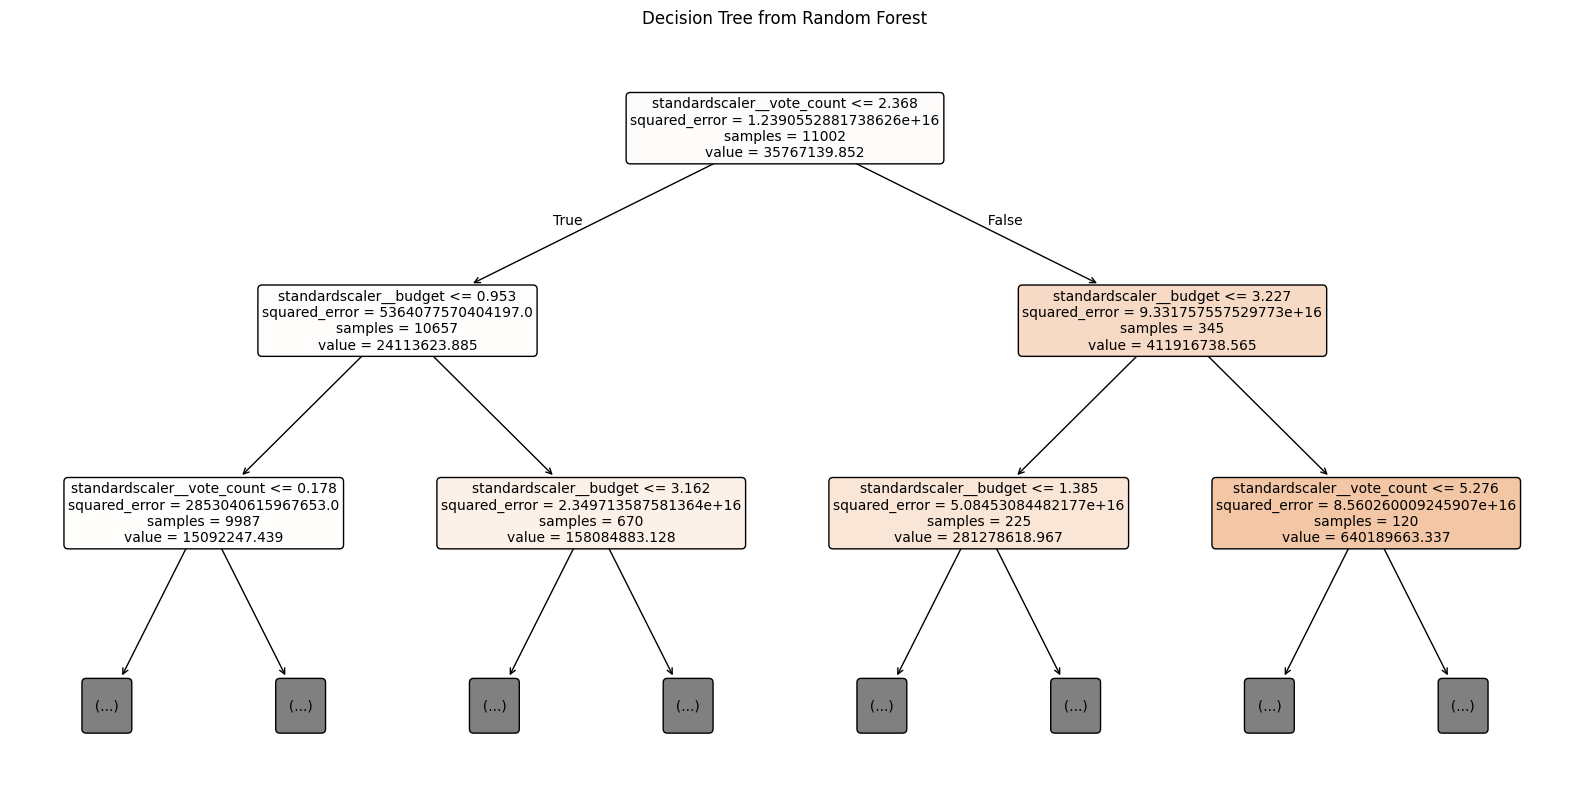

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('rforestreg', RandomForestRegressor())])
run_model('Random Forest, One Hot Encoder, and Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.675794 but overfitting

**Model 13**: Random forest with max depth 5 and polynomial features degree 2.

,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"Random Forest Max Depth 5, and Polynomial Features Degree 2",16.196957,3.540084e+15,5.609366e+15,2.168598e+07,2.444212e+07,0.559673,0.559145,,,


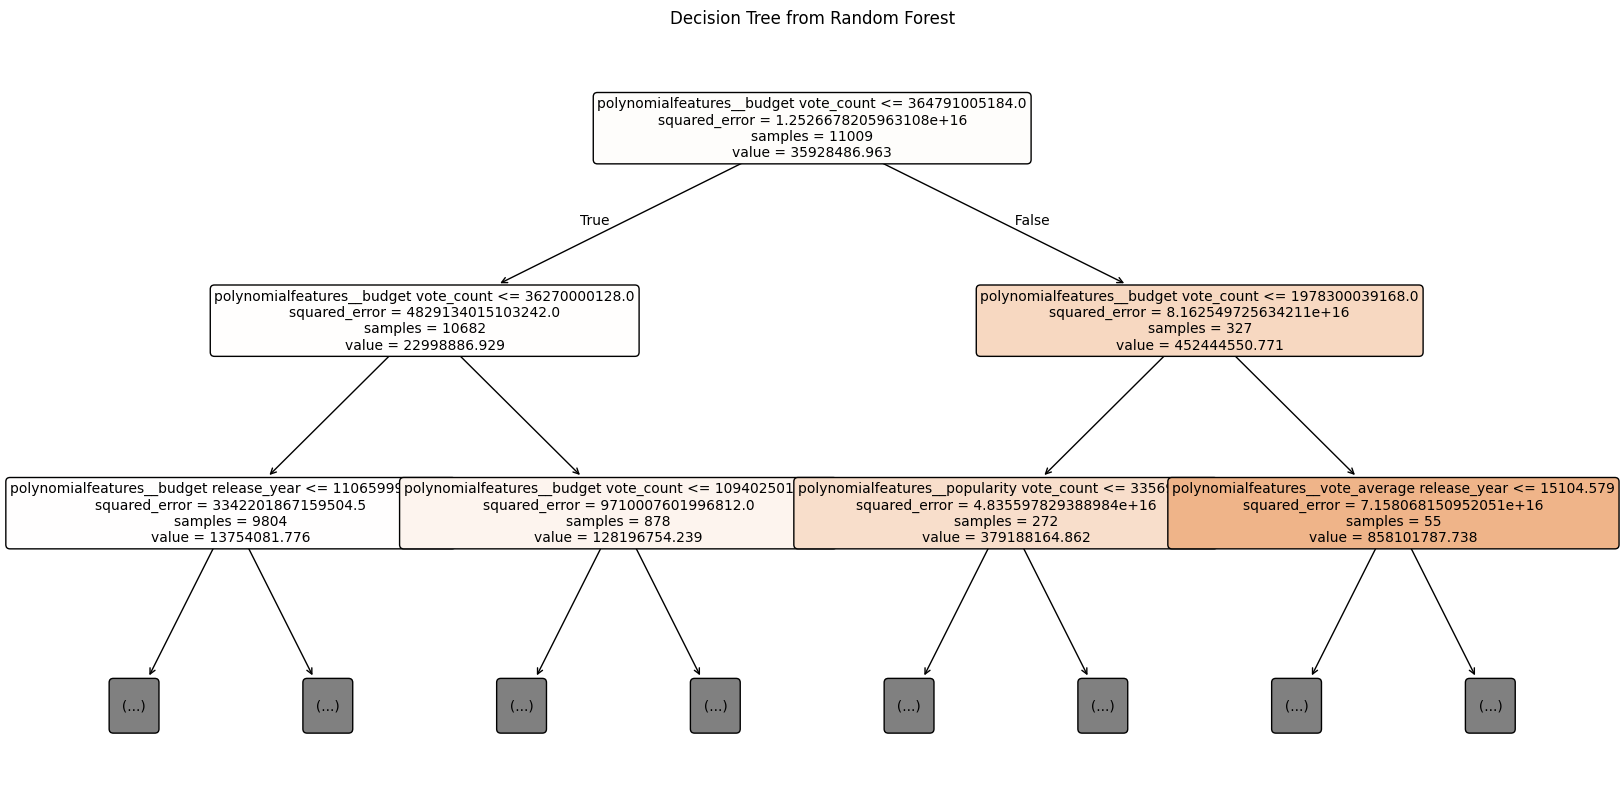

In [ ]:
X = prepared_movies[numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((PolynomialFeatures(include_bias=False, degree=2),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('rforestreg', RandomForestRegressor(max_depth=5))])
run_model('Random Forest Max Depth 5, and Polynomial Features Degree 2', pipe, X_train, X_test, y_train, y_test)

**Model 14**: Random forest with max depth 5, one hot encoder, and standard scaler.

,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"Random Forest Max Depth 5, and Polynomial Features Degree 2",5.642581,3.464642e+15,5.719672e+15,2.135048e+07,2.429750e+07,0.551014,0.548352,,,


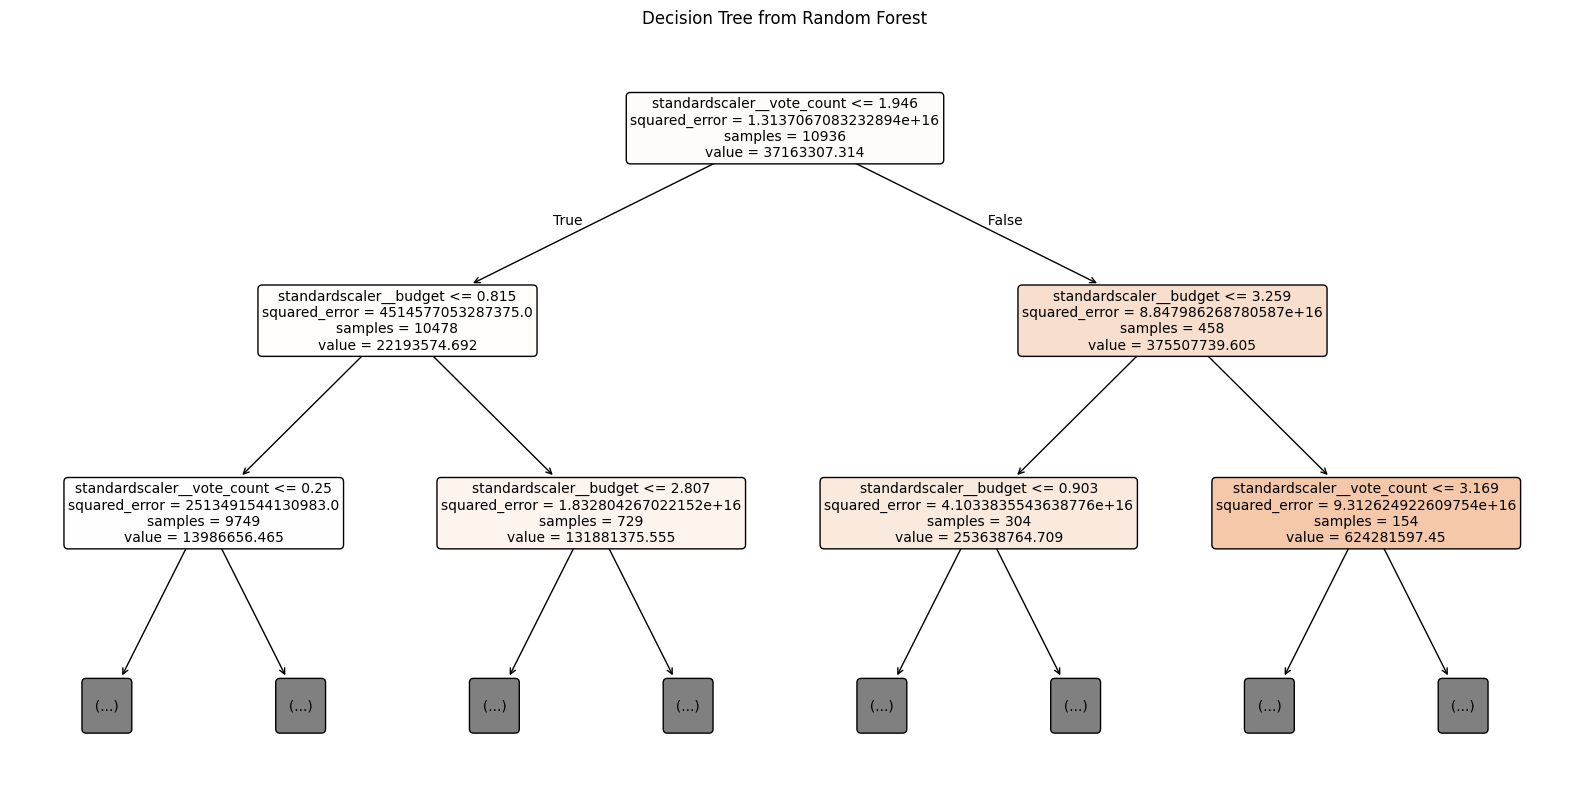

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('rforestreg', RandomForestRegressor(max_depth=5))])
run_model('Random Forest Max Depth 5, and Polynomial Features Degree 2', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.634928

**Model 15**: Random forest with max depth 5, one hot encoder, and polynomial features degree 2.

,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"Random Forest Max Depth 5, One Hot Encoder, and Polynomial Features Degree 2",19.948948,3.440110e+15,5.449028e+15,2.155652e+07,2.419804e+07,0.572259,0.569304,,,


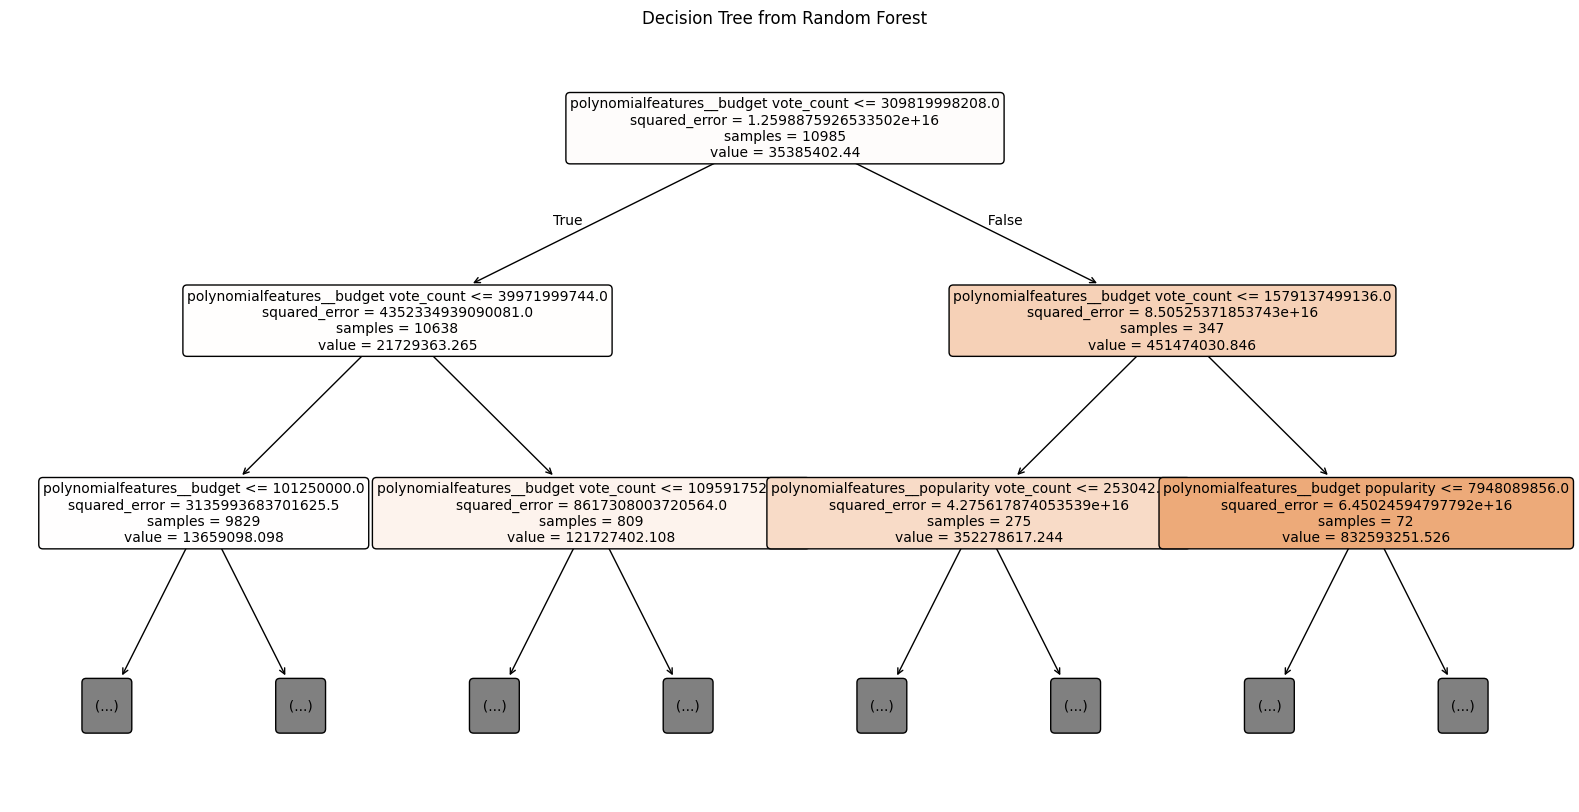

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (PolynomialFeatures(include_bias=False, degree=2),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('rforestreg', RandomForestRegressor(max_depth=5))])
run_model('Random Forest Max Depth 5, One Hot Encoder, and Polynomial Features Degree 2', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.634928

**Model 16**: Random forest max depth 10, one hot encoder, and standard scaler.

,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"Random Forest Max Depth 10, One Hot Encoder, Standard Scaler",19.270041,1.670697e+15,5.329383e+15,1.485111e+07,2.222168e+07,0.581651,0.57917,,,


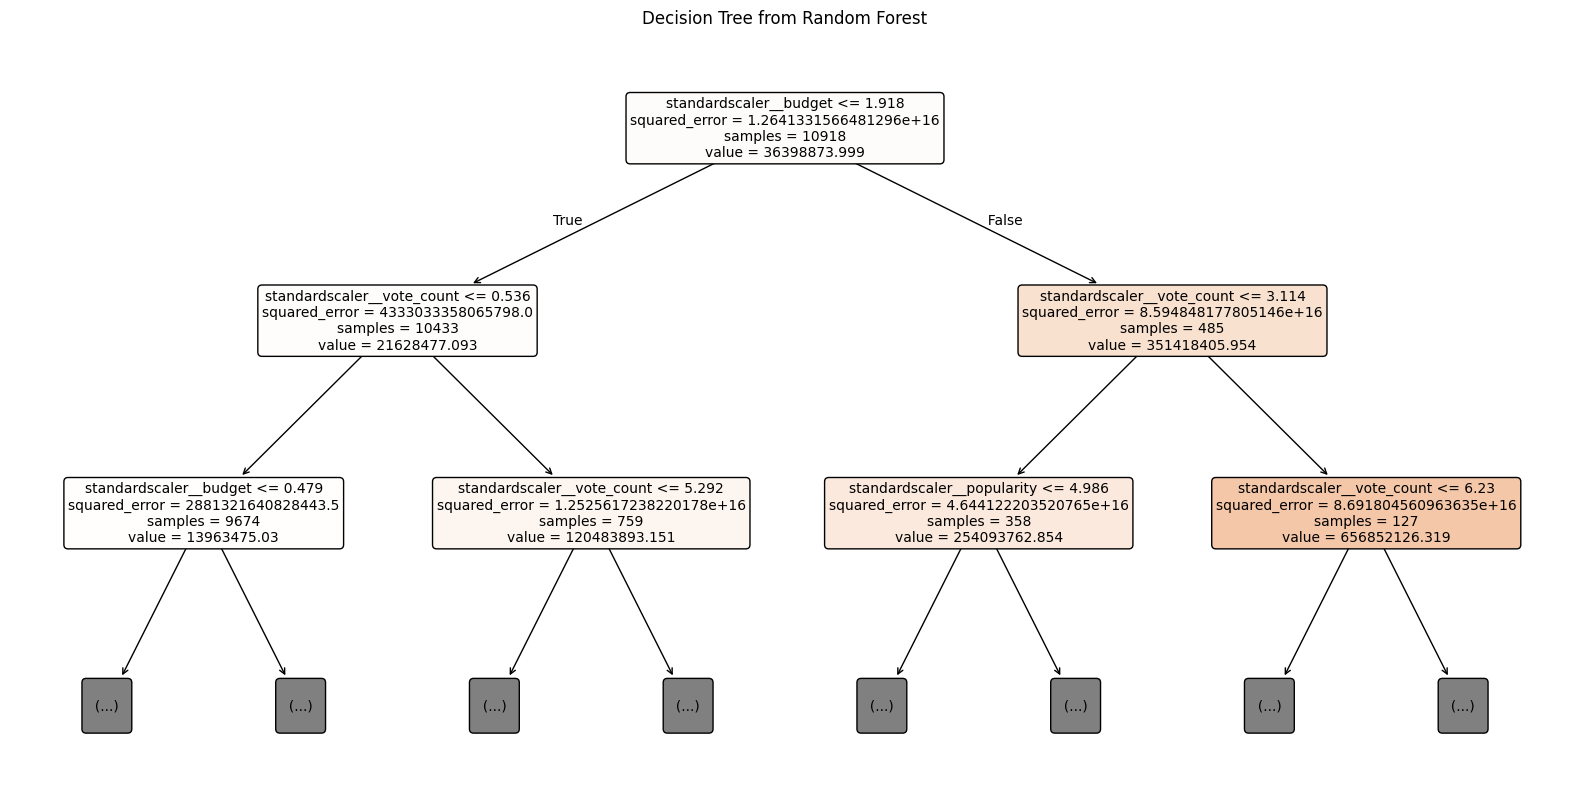

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('rforestreg', RandomForestRegressor(max_depth=10))])
run_model('Random Forest Max Depth 10, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.668651 but overfitting

**Model 17**: XGB regressor, one hot encoder, and standard scaler.

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))])
run_model('XGB Regressor, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.681771 but overfitting

,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"XGB Regressor, One Hot Encoder, Standard Scaler",2.10796,7.220901e+14,4.906579e+15,9896409.0,21480506.0,0.614841,0.612557,,,


**Model 18**: XGB regressor Max Depth 5 Estimators 5, one hot encoder, and standard scaler.

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('xgb', XGBRegressor(objective='reg:squarederror', max_depth=5, n_estimators=5, random_state=42))])
run_model('XGB Regressor Max Depth 5 Estimators 5, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.619128

,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"XGB Regressor Max Depth 5 Estimators 5, One Hot Encoder, Standard Scaler",0.410635,3.742264e+15,5.796907e+15,23548344.0,26109678.0,0.544951,0.542253,,,


**Model 19**: XGB regressor max depth 5 estimators 5, and polynomial features.

In [ ]:
X = prepared_movies[numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((PolynomialFeatures(include_bias=False, degree=2),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('xgb', XGBRegressor(objective='reg:squarederror', max_depth=5, n_estimators=5, random_state=42))])
run_model('XGB Regressor Max Depth 5 Estimators 5, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.619128

,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"XGB Regressor Max Depth 5 Estimators 5, One Hot Encoder, Standard Scaler",0.122518,3.770786e+15,5.688453e+15,23808950.0,26273830.0,0.553465,0.552929,,,


**Model 20**: XGB regressor max depth 5 estimators 5, one hot encoder, and polynomial features.

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (PolynomialFeatures(include_bias=False, degree=2),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('xgb', XGBRegressor(objective='reg:squarederror', max_depth=5, n_estimators=5, random_state=42))])
run_model('XGB Regressor Max Depth 5 Estimators 5, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.619128

,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"XGB Regressor Max Depth 5 Estimators 5, One Hot Encoder, Standard Scaler",0.486106,3.595996e+15,5.585317e+15,23333890.0,26058436.0,0.561561,0.558531,,,


**Model 21**: XGB regressor Max Depth 10 Estimators 10, one hot encoder, and standard scaler.

In [ ]:
X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('xgb', XGBRegressor(objective='reg:squarederror', max_depth=10, n_estimators=10, random_state=42))])
run_model('XGB Regressor Max Depth 10 Estimators 10, One Hot Encoder, Standard Scaler', pipe, X_train, X_test, y_train, y_test)
# Best Adjusted R2 Score: 0.658659 but overfitting

,Model,Train Time,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score,Selected Features,Selected Feature Ranking,Best Parameters
0,"XGB Regressor Max Depth 10 Estimators 10, One Hot Encoder, Standard Scaler",0.562794,1.039898e+15,5.640677e+15,10992634.0,22464636.0,0.557215,0.554589,,,


**Model 22**: Support Vector Machine with linear kernel, one hot encoder, and standard scaler.

In [ ]:
%%skip

X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('svm', SVC(kernel='linear'))])
grid = GridSearchCV(pipe, {'svm__C': [0.1, 1, 10], 'svm__gamma': [1, 10, 100] })
run_model('Support Vector Machine Linear Kernel, One Hot Encoder', grid, X_train, X_test, y_train, y_test)
# Is too slow and the runtime disconnects

**Model 23**: Support Vector Machine with poly kernel, one hot encoder, and standard scaler.

In [ ]:
%%skip

X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('svm', SVC(kernel='poly'))])
grid = GridSearchCV(pipe, {'svm__C': [0.1, 1, 10], 'svm__gamma': [1, 10, 100] })
run_model('Support Vector Machine Poly Kernel, One Hot Encoder', grid, X_train, X_test, y_train, y_test)
# Is too slow and the runtime disconnects

**Model 24**: Support Vector Machine with linear rbf, one hot encoder, and standard scaler.

In [ ]:
%%skip

X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('svm', SVC(kernel='rbf'))])
grid = GridSearchCV(pipe, {'svm__C': [0.1, 1, 10], 'svm__gamma': [1, 10, 100] })
run_model('Support Vector Machine RBF Kernel, One Hot Encoder', grid, X_train, X_test, y_train, y_test)
# Is too slow and the runtime disconnects

**Model 25**: Support Vector Machine with sigmoid kernel, one hot encoder, and standard scaler.

In [ ]:
%%skip

X = prepared_movies[categorical_columns + numerical_columns]
y = prepared_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns))
pipe = Pipeline([('transformer', transformer), ('svm', SVC(kernel='sigmoid'))])
grid = GridSearchCV(pipe, {'svm__C': [0.1, 1, 10], 'svm__gamma': [1, 10, 100] })
run_model('Support Vector Machine Sigmoid Kernel, One Hot Encoder', pipe, X_train, X_test, y_train, y_test)
# Is too slow and the runtime disconnects

### Evaluation

In [ ]:
pd.DataFrame(results)[['Model', 'Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'R2 Score', 'Adjusted R2 Score']].sort_values(by='Adjusted R2 Score', ascending=False)

,Model,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Adjusted R2 Score
17,"XGB Regressor, One Hot Encoder, Standard Scaler",7.220901e+14,4.906579e+15,9.896409e+06,2.148051e+07,0.614841,0.612557
12,"Random Forest, One Hot Encoder, and Standard Scaler",5.449341e+14,5.232884e+15,7.484094e+06,2.163102e+07,0.589226,0.586790
16,"Random Forest Max Depth 10, One Hot Encoder, Standard Scaler",1.670697e+15,5.329383e+15,1.485111e+07,2.222168e+07,0.581651,0.579170
15,"Random Forest Max Depth 5, One Hot Encoder, and Polynomial Features Degree 2",3.440110e+15,5.449028e+15,2.155652e+07,2.419804e+07,0.572259,0.569304
13,"Random Forest Max Depth 5, and Polynomial Features Degree 2",3.540084e+15,5.609366e+15,2.168598e+07,2.444212e+07,0.559673,0.559145
20,"XGB Regressor Max Depth 5 Estimators 5, One Hot Encoder, Standard Scaler",3.595996e+15,5.585317e+15,2.333389e+07,2.605844e+07,0.561561,0.558531
21,"XGB Regressor Max Depth 10 Estimators 10, One Hot Encoder, Standard Scaler",1.039898e+15,5.640677e+15,1.099263e+07,2.246464e+07,0.557215,0.554589
19,"XGB Regressor Max Depth 5 Estimators 5, One Hot Encoder, Standard Scaler",3.770786e+15,5.688453e+15,2.380895e+07,2.627383e+07,0.553465,0.552929
14,"Random Forest Max Depth 5, and Polynomial Features Degree 2",3.464642e+15,5.719672e+15,2.135048e+07,2.429750e+07,0.551014,0.548352
18,"XGB Regressor Max Depth 5 Estimators 5, One Hot Encoder, Standard Scaler",3.742264e+15,5.796907e+15,2.354834e+07,2.610968e+07,0.544951,0.542253
